In [461]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

In [462]:
df = pd.read_csv("../../our_analyses/dataset_prepared.csv")

In [463]:

from sklearn.preprocessing import LabelEncoder

df=df.drop(['name', 'artists', 'album_name'], axis=1)

# genre_groups = {
#     'j-dance': 0, 'techno': 0, 'mandopop': 0, 'idm': 0, 'chicago-house': 0, 'breakbeat': 0,  # Elettronica/Dance
#     'black-metal': 1,  # Metal/Rock
#     'bluegrass': 2,  # Country/Folk
#     'j-idol': 3, 'spanish': 3, 'disney': 3, 'brazil': 3,  # Pop/Commerciale
#     'iranian': 4, 'afrobeat': 4, 'indian': 4, 'forro': 4,  # World
#     'happy': 5, 'sleep': 5, 'study': 5,  # Ambient/New Age
#     'industrial': 6  # Other
# }
genre_groups = {
    'j-dance': 0, 'techno': 0, 'chicago-house': 0, 'breakbeat': 0, 'idm': 0, 
        'happy': 1, 'sleep': 1, 'study': 1, 'disney': 1, 
        'bluegrass': 2, 'forro': 2, 'mandopop': 2, 'iranian': 2, 'indian': 2, 'brazil': 2, 
        'black-metal': 3, 'industrial': 3, 
        'j-idol': 4, 'spanish': 4, 'afrobeat': 4, 
}

# Mappatura dei generi del dataframe ai gruppi di generi
df['genre_group'] = df['genre'].map(genre_groups).astype(int)

# Stampa del mapping dei generi ai numeri corrispondenti
print(df['genre_group'].unique())

le = LabelEncoder()
df['explicit'] = le.fit_transform(df['explicit'])

drop_attributes=[ 'mode', 'time_signature', 'key', 'genre'] #, 'mode', 'time_signature']
df = df.drop(drop_attributes, axis=1)

[4 3 2 0 1]


## Data cleaning

In [464]:
# # # Filtro per rimuovere le righe con tempo=0 e non appartenenti ai genre_group 2 e 4
# df = df[~((df['tempo'] == 0) & (~df['genre_group'].isin([1])))]

# # # Filtro per rimuovere le righe con acousticness e energy > 0.8 e non appartenenti ai genre_group 1 e 2
# df = df[~((df['acousticness'] > 0.7) & (df['energy'] > 0.7) & (~df['genre_group'].isin([1])))]
# df = df[~((df['acousticness'] < 0.3) & (df['energy'] < 0.3) & (~df['genre_group'].isin([1])))]

# # Il DataFrame 'df' ora contiene solo le righe che soddisfano le tue condizioni

# # Calcola i quantili per 'popularity'
# Q1 = df['popularity'].quantile(0.2)
# Q2 = df['popularity'].quantile(0.4)
# Q3 = df['popularity'].quantile(0.60)
# Q4 = df['popularity'].quantile(0.80)

# # Definisci gli intervalli di bin
# bin_edges = [-1, Q1, Q2, Q3, Q4, df['popularity'].max()]
# bin_labels = ['Very Low Popularity', 'Low Popularity', 'Medium Popularity', 'High Popularity', 'Very High Popularity']


# # Crea la colonna 'popularity_category' con i valori discretizzati
# df['popularity_category'] = pd.cut(df['popularity'], bins=bin_edges, labels=bin_labels)
# df=df.drop(["popularity"], axis=1)

# le = LabelEncoder()
# df['popularity_category'] = le.fit_transform(df['popularity_category'])

# df.head()

In [465]:
from sklearn.model_selection import train_test_split

attributes = [col for col in df.columns if col != 'genre_group']
X = df[attributes].value
y = df['genre_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y) # we use 70% and 30% and we stratisfy to have the same distribution for the classes between them in the training and in the test set

In [466]:
from sklearn.preprocessing import StandardScaler

norm = StandardScaler()
norm.fit(X_train)

X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

In [467]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [468]:
# I tuoi iperparametri ottimizzati
best_params_well = {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 4, 'min_samples_split': 40}


# Istanzia il modello con i migliori iperparametri
dt = DecisionTreeClassifier(**best_params_well, ccp_alpha=0.000428359788359789)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.000428359788359789, criterion='entropy',
                       max_depth=10, min_impurity_decrease=0.001,
                       min_samples_leaf=4, min_samples_split=40)

# Costruzione efficace di un albero decisionale

## Prevenire l'overfitting:

- **Scegli il miglior punto di divisione** basato su misure come l'indice di Gini o l'entropia.
- **Pre-potatura**: Interrompi la crescita dell'albero precocemente seguendo criteri come l'omogeneità delle istanze.
- **Post-potatura**: Semplifica un albero completamente sviluppato usando stime dell'errore di generalizzazione.
- **Gestione degli attributi**: Gestisci attributi continui e categorici in modo appropriato.
- **Convalida incrociata**: Applica metodi come la convalida incrociata per stimare errori di generalizzazione.

## Parametri `best_params_well`:

| Parametro                | Descrizione                                            |
|--------------------------|--------------------------------------------------------|
| `criterion: 'entropy'`   | Misura usata per la qualità di una divisione.          |
| `max_depth: 10`          | Profondità massima dell'albero.                        |
| `max_features: None`     | Numero di funzionalità da considerare per il miglior taglio. |
| `min_impurity_decrease`  | Soglia per la riduzione dell'impurità.                 |
| `min_samples_leaf: 4`    | Numero minimo di campioni richiesti per essere una foglia.  |
| `min_samples_split: 40`  | Numero minimo di campioni richiesti per dividere un nodo interno. |
| `splitter: 'best'`       | Strategia utilizzata per scegliere la divisione a ogni nodo. |
| `ccp_alpha`              | Parametro per la potatura basata sui costi di complessità.    |

## Tecniche di pre-pruning:

- `max_depth`: Limita la profondità massima dell'albero.
- `min_samples_split`: Stabilisce il numero minimo di campioni che un nodo deve avere prima di poter essere diviso.
- `min_samples_leaf`: Definisce il numero minimo di campioni che una foglia deve avere.
- `min_impurity_decrease`: Un nodo sarà diviso solo se questa divisione induce una diminuzione dell'impurità maggiore di questo valore.

## Tecnica di post-pruning:

- `ccp_alpha`: Parametro per la potatura basata sui costi di complessità, usato per rimuovere le parti dell'albero che forniscono poco potere predittivo a fronte di una complessità maggiore.

**Nota**: Gli attributi come `criterion` e `splitter` sono parametri generali per la costruzione dell'albero e non sono specifici delle tecniche di pre-pruning o post-pruning.


In [469]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

In [470]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))

Train Accuracy 0.714
Train F1-score [0.72540984 0.73894437 0.78311111 0.68167539 0.50759219]

Test Accuracy 0.6591111111111111
Test F1-score [0.68043011 0.66365688 0.73556019 0.60363636 0.46677741]


In [471]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.66      0.70      0.68      1125
           1       0.67      0.65      0.66       900
           2       0.69      0.78      0.74      1350
           3       0.66      0.55      0.60       450
           4       0.53      0.42      0.47       675

    accuracy                           0.66      4500
   macro avg       0.64      0.62      0.63      4500
weighted avg       0.65      0.66      0.65      4500



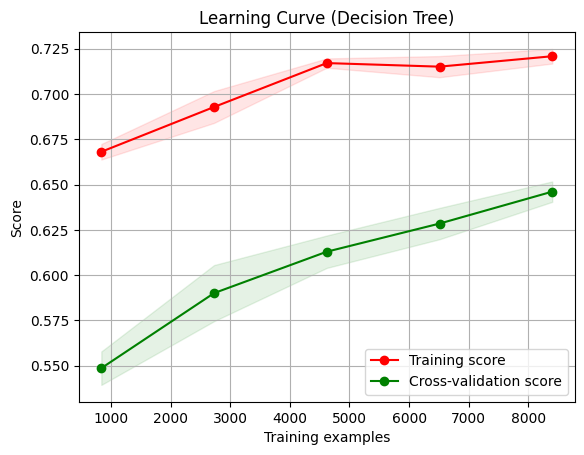

In [472]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Assicurati che il Decision Tree Classifier 'dt' sia già stato definito e addestrato qui

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot della curva di apprendimento per il tuo classificatore
plot_learning_curve(dt, "Learning Curve (Decision Tree)", X_train_norm, y_train, cv=5)

# Mostra il plot
plt.show()


In [473]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

# Assumiamo che 'y_test' e 'y_test_pred' siano già definiti e contengano le etichette vere e predette dal tuo modello

# Genera la matrice di confusione
cf = confusion_matrix(y_test, y_test_pred)

# Definisci le etichette per i generi in base ai raggruppamenti definiti
genre_labels = ['Dance/Electronic', 'Ambient/Relaxing', 'Global/Traditional', 'Metal/Industrial', 'Pop/World']

# Crea la heatmap usando plotly
fig = ff.create_annotated_heatmap(z=cf, x=genre_labels, y=genre_labels,
                                  annotation_text=cf.astype(str), colorscale='Greens')

# Aggiorna il layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5,
                  xaxis=dict(title='Predicted Labels', tickangle=45),
                  yaxis=dict(title='True Labels', tickmode='array', tickvals=list(range(len(genre_labels))), ticktext=genre_labels),
                  yaxis_autorange='reversed')  # Reverse the y-axis to have the first class at the top

# Mostra il grafico
fig.show()


In [474]:
zipped = zip(attributes, dt.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

acousticness 0.22687004063688893
popularity 0.16231468506343183
danceability 0.13820106048395664
duration_ms 0.1302336594689303
instrumentalness 0.11996116703487092
valence 0.048230993635619765
speechiness 0.04588950791510176
loudness 0.04252519592307843
energy 0.042445046493656914
tempo 0.02891947311661566
explicit 0.012648215351159203
liveness 0.001760954876689386


#### Decision Tree hyperparameters

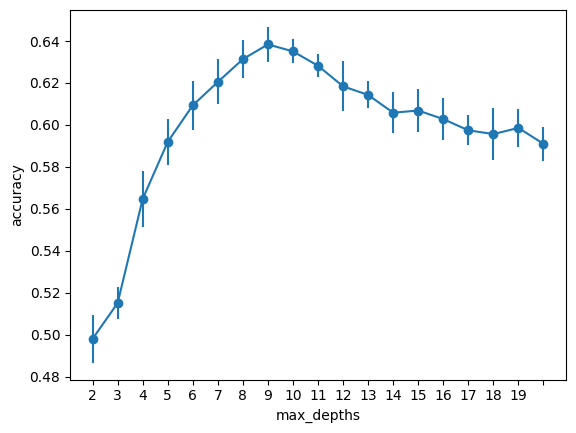

In [475]:
from sklearn.model_selection import cross_val_score

max_depths =  list(np.arange(2, 20)) + [None]
avg_scores = list()
std_scores = list()

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(max_depths)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(max_depths)), max_depths)
plt.xlabel("max_depths")
plt.ylabel("accuracy")
plt.show()

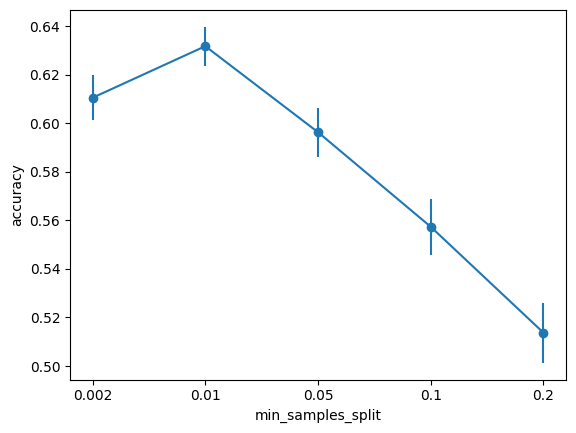

In [476]:
min_samples_splits = [0.002, 0.01, 0.05, 0.1, 0.2]
avg_scores = list()
std_scores = list()

for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(min_samples_splits)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_splits)), min_samples_splits)
plt.xlabel("min_samples_split") 
plt.ylabel("accuracy")
plt.show()

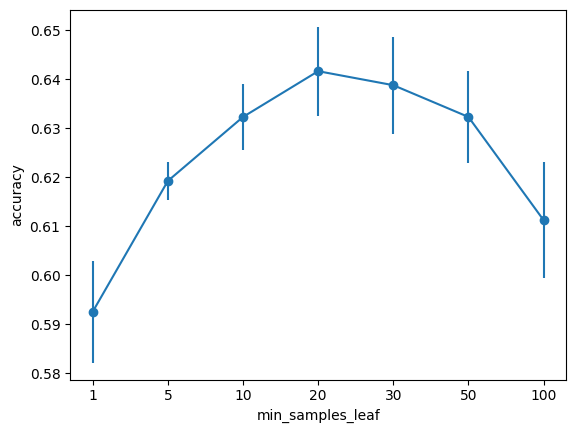

In [477]:
min_samples_leafs = [1, 5, 10, 20, 30, 50, 100]
avg_scores = list()
std_scores = list()

for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(min_samples_leafs)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_leafs)), min_samples_leafs)
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracy")
plt.show()

### Randomized search

In [478]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [479]:
from sklearn.model_selection import GridSearchCV

# Configura una nuova ricerca grid con parametri aggiuntivi o intervalli estesi
param_grid = {
    'max_depth': [None] + list(np.arange(5, 20)),
    'min_samples_split': [2, 5, 10, 20, 40],
    'min_samples_leaf': [1, 4, 10, 20, 40],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'min_impurity_decrease': [0, 0.1, 0.01, 0.001, 0.0001],
    'splitter': ["best", "random"]
}

# Esegui la ricerca grid
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_norm, y_train)

# Valuta il miglior modello trovato sulla ricerca grid
best_tree = grid_search.best_estimator_
print(f'Migliori parametri trovati: {grid_search.best_params_}')
print(f'Punteggio del miglior modello: {grid_search.best_score_}')

# Prova ensemble learning con Random Forest
from sklearn.ensemble import RandomForestClassifier

# Configura e addestra il RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
rf_clf.fit(X_train_norm, y_train)

# Valuta il RandomForestClassifier
rf_train_acc = rf_clf.score(X_train_norm, y_train)
rf_test_acc = rf_clf.score(X_test_norm, y_test)
print(f'Random Forest train accuracy: {rf_train_acc}')
print(f'Random Forest test accuracy: {rf_test_acc}')


Fitting 5 folds for each of 24000 candidates, totalling 120000 fits
Migliori parametri trovati: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 4, 'min_samples_split': 40, 'splitter': 'best'}
Punteggio del miglior modello: 0.6460952380952382
Random Forest train accuracy: 1.0
Random Forest test accuracy: 0.7208888888888889


Test Accuracy: 0.6591111111111111
Test F1 Score: 0.6538872099713219


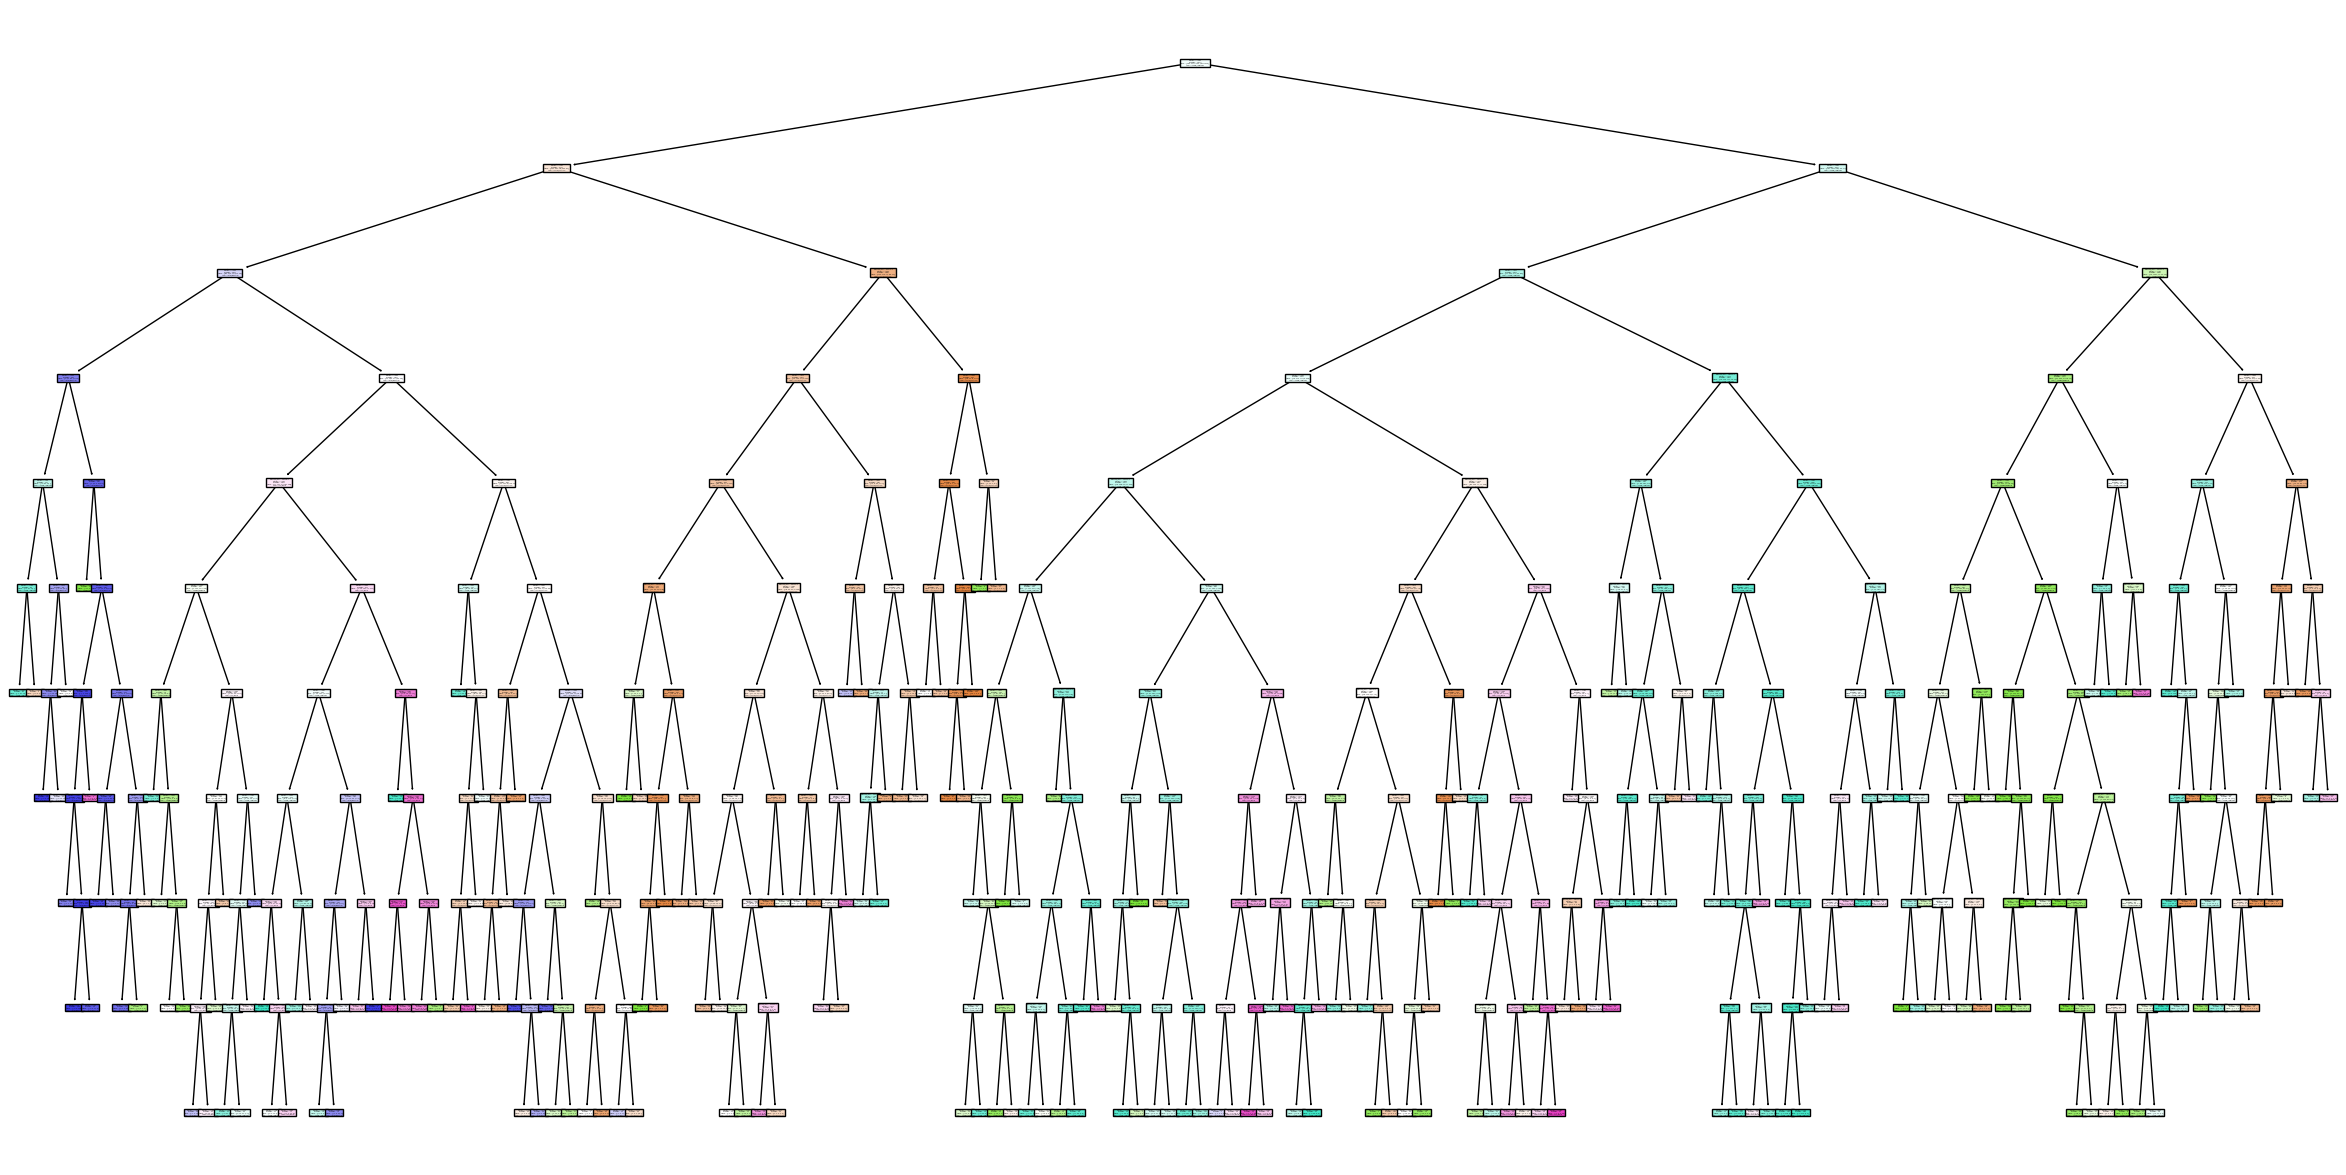

In [480]:
from sklearn.tree import DecisionTreeClassifier

# I tuoi iperparametri ottimizzati
# best_params = {'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 4, 'min_samples_split': 40}


# Istanzia il modello con i migliori iperparametri
dt_optimized = DecisionTreeClassifier(**grid_search.best_params_)

# Addestra il modello
dt_optimized.fit(X_train, y_train)

# Effettua previsioni sul set di test
y_test_pred_optimized = dt_optimized.predict(X_test)
y_train_pred_optimized = dt_optimized.predict(X_train)

# Valuta il modello
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred, average='weighted') # 'weighted' tiene conto del bilanciamento delle classi

print(f'Test Accuracy: {test_accuracy}')
print(f'Test F1 Score: {test_f1_score}')

# Se desideri visualizzare l'albero decisionale
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(30,15))
plot_tree(dt_optimized, feature_names=attributes, class_names=genre_labels, filled=True)
plt.show()


In [481]:
import plotly.graph_objs as go
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Assicurati che Z_train, Z_test, t_train, e t_test siano definiti e che i tuoi dati siano già preelaborati
# Z_train, Z_test, t_train, t_test = ...

# Previsione delle probabilità per il set di test
y_score = dt_optimized.predict_proba(X_test)

# Binarizza il vettore delle etichette in un formato "one-vs-all"
y_test_binarize = label_binarize(y_test, classes=np.unique(y_train))

# Calcola ROC curve e AUC per ciascuna classe
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_score.shape[1]

# Preparare i dati per il plot
traces = []

# Calcola la ROC curve per ogni classe
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    traces.append(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', 
                             name=f'Class {i} (AUC = {roc_auc[i]:.2f})'))

# Aggiungi la linea diagonale che rappresenta il caso di "indovinare casualmente"
traces.append(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Chance', 
                         line=dict(dash='dash')))

# Crea il layout del plot
layout = go.Layout(title='Multiclass ROC Curve',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'),
                   width=1000,
                   height=800,
                   showlegend=True,
                   legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

fig = go.Figure(data=traces, layout=layout)
fig.show()


In [482]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred_optimized))
print('Train F1-score %s' % f1_score(y_train, y_train_pred_optimized, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred_optimized))
print('Test F1-score %s' % f1_score(y_test, y_test_pred_optimized, average=None))

Train Accuracy 0.714
Train F1-score [0.72540984 0.73894437 0.78311111 0.68167539 0.50759219]

Test Accuracy 0.6591111111111111
Test F1-score [0.68043011 0.66365688 0.73556019 0.60363636 0.46677741]


In [483]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

# Assumiamo che 'y_test' e 'y_test_pred' siano già definiti e contengano le etichette vere e predette dal tuo modello

# Genera la matrice di confusione
cf = confusion_matrix(y_test, y_test_pred_optimized)

# Definisci le etichette per i generi in base ai raggruppamenti definiti
genre_labels = ['Dance/Electronic', 'Ambient/Relaxing', 'Global/Traditional', 'Metal/Industrial', 'Pop/World']

# Crea la heatmap usando plotly
fig = ff.create_annotated_heatmap(z=cf, x=genre_labels, y=genre_labels,
                                  annotation_text=cf.astype(str), colorscale='Greens')

# Aggiorna il layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5,
                  xaxis=dict(title='Predicted Labels', tickangle=45),
                  yaxis=dict(title='True Labels', tickmode='array', tickvals=list(range(len(genre_labels))), ticktext=genre_labels),
                  yaxis_autorange='reversed')  # Reverse the y-axis to have the first class at the top

# Mostra il grafico
fig.show()


In [484]:
path = dt_optimized.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [485]:

# Esegui la cross-validation per ogni valore di ccp_alpha e raccogli i punteggi di accuratezza
cv_scores = []
for ccp_alpha in ccp_alphas:
    dt_cv = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    scores = cross_val_score(dt_cv, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(np.mean(scores))

# Trova il valore di ccp_alpha che massimizza l'accuratezza media della cross-validation
best_ccp_alpha_index = np.argmax(cv_scores)
best_ccp_alpha = ccp_alphas[best_ccp_alpha_index]

# Stampa dei risultati per ccp_alpha
print(f"Best ccp_alpha: {best_ccp_alpha} with cross-validated accuracy: {cv_scores[best_ccp_alpha_index]}")

Best ccp_alpha: 0.0010079028497507738 with cross-validated accuracy: 0.6366666666666667


In [486]:
for alpha, imp in zip(ccp_alphas, impurities):
    print(alpha, imp)

0.0 1.0398885290626256
0.0010079028497507738 1.0408964319123764
0.0010293567049273653 1.0419257886173037
0.0010303283908735163 1.0429561170081771
0.0010329963437367906 1.043989113351914
0.0010351967282058241 1.0450243100801198
0.0010458380919199269 1.0460701481720396
0.0010622279414577458 1.0471323761134974
0.001062257285941435 1.0481946333994387
0.0010633851743249824 1.0492580185737637
0.001070111976577831 1.0503281305503416
0.0010715843780216864 1.0513997149283634
0.001077270665045009 1.0524769855934084
0.0011253551617614599 1.0536023407551698
0.0011293610047546391 1.0547317017599245
0.0011453285968017718 1.0558770303567262
0.0011458501080192866 1.0570228804647455
0.0011579251630669243 1.0581808056278124
0.001162120584555934 1.0593429262123684
0.0011702149641248894 1.061683356140618
0.0011717806883501216 1.0628551368289683
0.001179211946177327 1.0640343487751456
0.00118147950838288 1.0652158282835285
0.001182363024301753 1.0663981913078302
0.0011860473750433605 1.0675842386828736
0.0

Impurità Totale vs Alpha Efficace: Questo grafico illustra l'impurità totale delle foglie dell'albero al variare del parametro ccp_alpha. Con valori bassi di alpha, l'albero è complesso con bassa impurità. Man mano che alpha aumenta, le impurità aumentano perché l'albero si semplifica, eliminando divisioni che contribuiscono poco alla riduzione dell'impurità.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

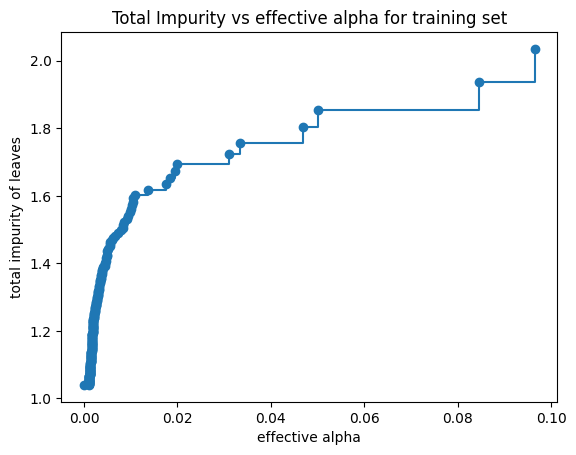

In [487]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [488]:
random_search.best_params_

{'min_samples_split': 30,
 'min_samples_leaf': 20,
 'max_depth': 10,
 'criterion': 'entropy'}

In [489]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, **random_search.best_params_)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.19308170520078827


Numero di Nodi vs Alpha: Dimostra come il numero di nodi nell'albero diminuisce significativamente all'aumentare di alpha. Un numero ridotto di nodi implica un modello più semplice ma possibilmente meno adatto a catturare le sottigliezze dei dati.

Profondità vs Alpha: Mostra la profondità dell'albero in relazione a diversi valori di alpha. Più è alto il valore di alpha, più l'albero viene potato, risultando in una profondità minore e potenzialmente una maggiore generalizzazione.

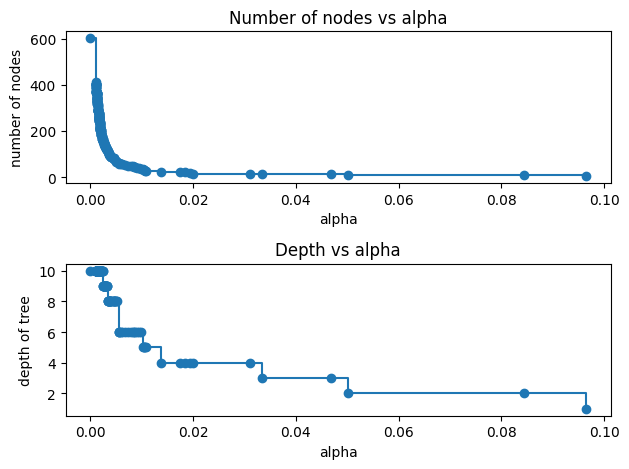

In [490]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Accuratezza vs Alpha per Set di Addestramento e Test: Questo grafico confronta l'accuratezza sui set di addestramento e test. Un buon valore di alpha è colui che mantiene alta l'accuratezza sui dati di addestramento mentre massimizza l'accuratezza sui dati di test. La scelta di alpha si basa su un compromesso tra prestazioni e complessità, cercando un punto in cui l'accuratezza si stabilizza prima di diminuire drasticamente, indicando un buon equilibrio tra adattamento e generalizzazione.

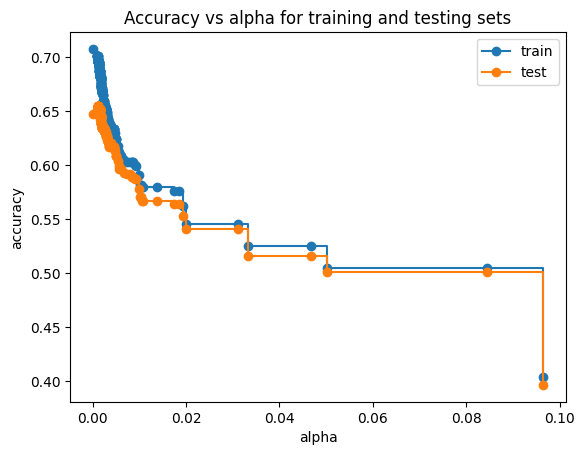

In [491]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

Per scegliere il ccp_alpha, considereremmo il grafico "Accuracy vs Alpha per i set di addestramento e test". Sceglieremmo un valore di alpha che massimizza l'accuratezza sui dati di test mantenendo ancora buone prestazioni sui dati di addestramento. Il punto ideale sarebbe appena prima che l'accuratezza sul test inizi a diminuire o dove l'accuratezza di test si stabilizza. Questo ci indica che il modello è abbastanza generalizzato per gestire nuovi dati ma non troppo semplificato da perdere l'accuratezza predittiva. Analizzando i grafici forniti, potremmo considerare un valore di alpha intorno a 0.01, dove sembra esserci un equilibrio tra complessità e accuratezza. Tuttavia, questa è solo una stima visiva; per una scelta definitiva, potremmo voler analizzare ulteriormente i risultati o eseguire validazioni aggiuntive.

In [492]:
best_params_well = {'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'min_impurity_decrease': 0, 'min_samples_leaf': 10, 'min_samples_split': 40, 'splitter': 'best'}
dtp = DecisionTreeClassifier(random_state=0, ccp_alpha=0.01, **best_params_well)
dtp.fit(X_train, y_train)

y_test_pred = dtp.predict(X_test)
y_train_pred = dtp.predict(X_train)

In [493]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))

Train Accuracy 0.6983809523809524
Train F1-score [0.71825032 0.71655329 0.77548525 0.65277778 0.50280435]

Test Accuracy 0.6482222222222223
Test F1-score [0.67459643 0.64812576 0.72688017 0.58823529 0.47845468]


In [494]:
y_test_pred = dtp.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.6482222222222223


In [495]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.65      0.71      0.67      1125
           1       0.71      0.60      0.65       900
           2       0.71      0.75      0.73      1350
           3       0.61      0.57      0.59       450
           4       0.48      0.48      0.48       675

    accuracy                           0.65      4500
   macro avg       0.63      0.62      0.62      4500
weighted avg       0.65      0.65      0.65      4500



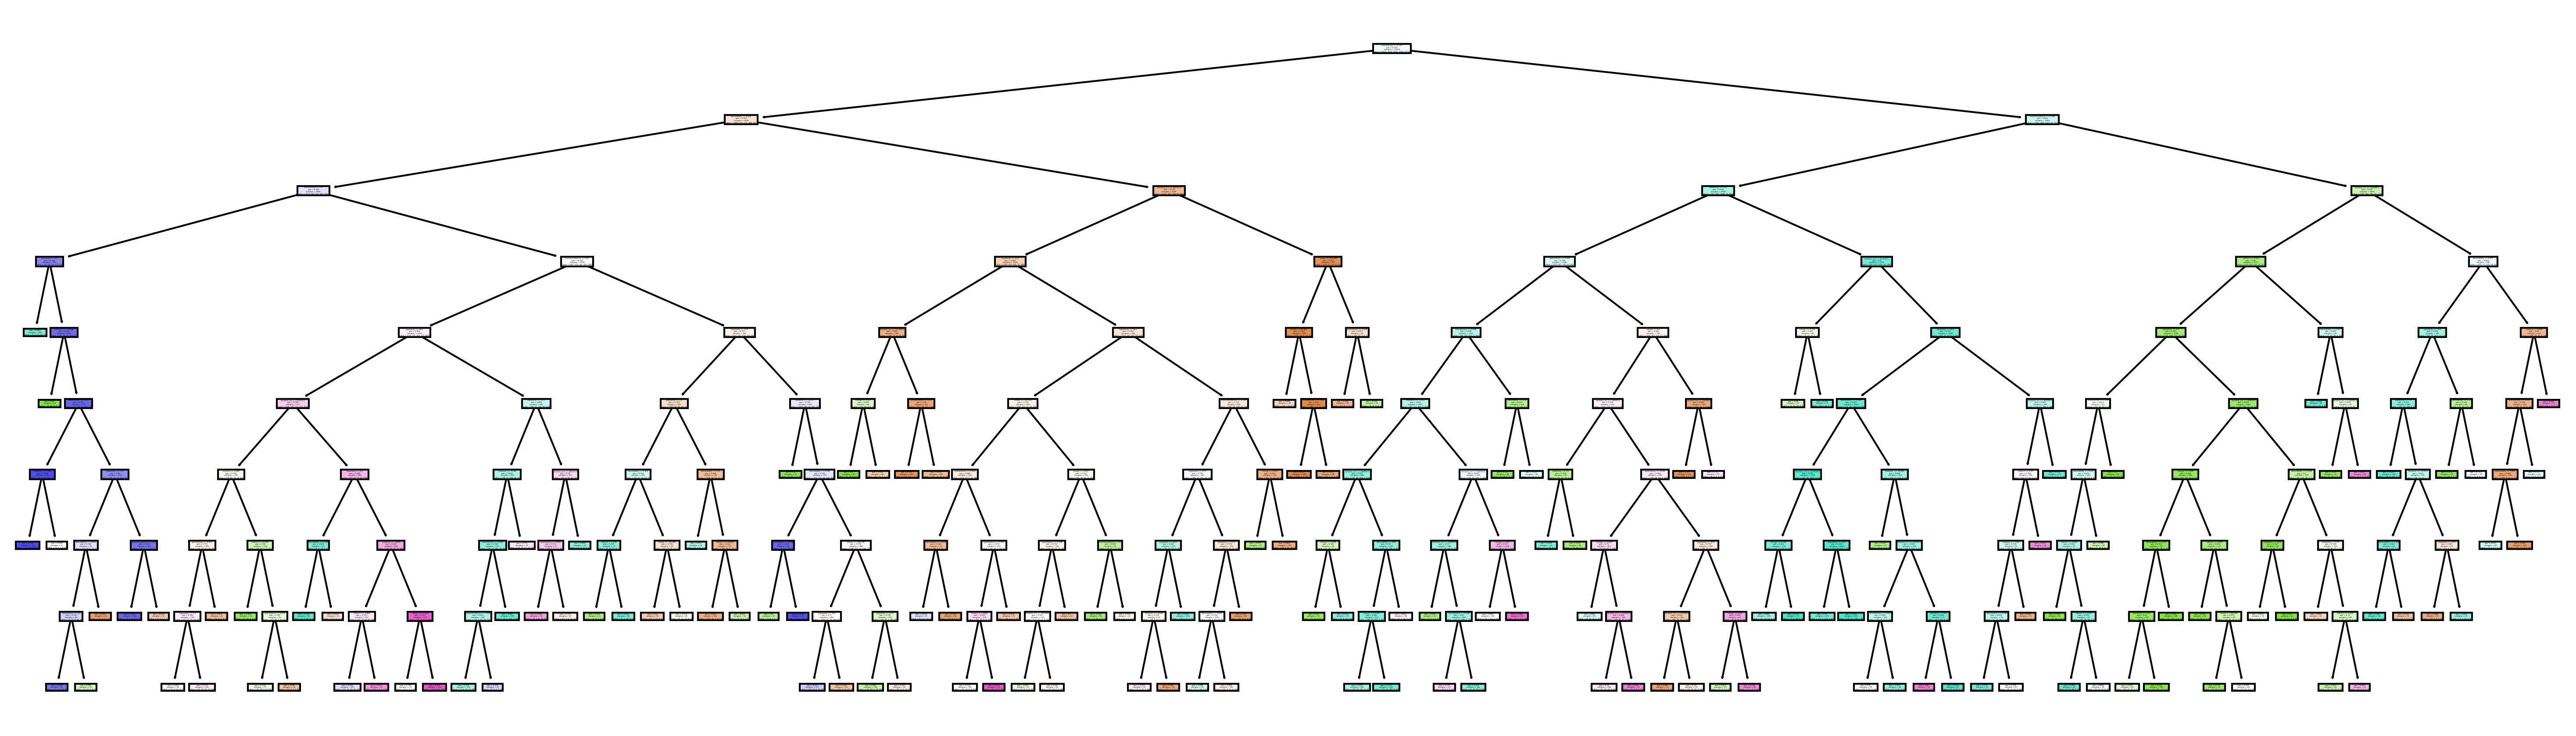

In [502]:
plt.figure(figsize=(25, 7), dpi=300)
plot_tree(dtp, feature_names=attributes, filled=True)
plt.show()

In [497]:
import plotly.graph_objs as go
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Assicurati che Z_train, Z_test, t_train, e t_test siano definiti e che i tuoi dati siano già preelaborati
# Z_train, Z_test, t_train, t_test = ...

# Previsione delle probabilità per il set di test
y_score = dtp.predict_proba(X_test)

# Binarizza il vettore delle etichette in un formato "one-vs-all"
y_test_binarize = label_binarize(y_test, classes=np.unique(y_train))

# Calcola ROC curve e AUC per ciascuna classe
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_score.shape[1]

# Preparare i dati per il plot
traces = []

# Calcola la ROC curve per ogni classe
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    traces.append(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', 
                             name=f'Class {i} (AUC = {roc_auc[i]:.2f})'))

# Aggiungi la linea diagonale che rappresenta il caso di "indovinare casualmente"
traces.append(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Chance', 
                         line=dict(dash='dash')))

# Crea il layout del plot
layout = go.Layout(title='Multiclass ROC Curve',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'),
                   width=1000,
                   height=800,
                   showlegend=True,
                   legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

fig = go.Figure(data=traces, layout=layout)
fig.show()
